# Compute FWC, MLD, and OHC and save ZARR datasets

In [1]:
## import required packages
import numpy as np
import pandas as pd
import sys
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import cmocean
import gsw
import matplotlib.dates as mdates
import time
import cartopy.crs as ccrs
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", module='distributed')

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45187")
client

<Client: 'tcp://127.0.0.1:45187' processes=8 threads=32, memory=123.95 GiB>

In [3]:
# initialize s3 filesystem
s3_options = dict(anon=False)

In [4]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [5]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

### Open daily mean ZARR datasets

In [6]:
# open SALT zarr store - [psu]
salt_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SALT_AVG_DAILY.ZARR/', s3_options).SALT

# open THETA zarr store - [degC]
theta_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/THETA_AVG_DAILY.ZARR/', s3_options).THETA

# open SIarea zarr store - [fraction of sea ice, 0 to 1]
ice_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SIarea_AVG_DAILY.ZARR/', s3_options).SIarea*100

# open density zarr store - [kg m-3]
rho_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/RHOAnoma_AVG_DAILY.ZARR/', s3_options).RHOAnoma + 1027.5

In [7]:
# carve out beaufort region
salt_beaufort = salt_da.isel(i=slice(510,750),j=slice(110,390))
theta_beaufort = theta_da.isel(i=slice(510,750),j=slice(110,390))
ice_beaufort = ice_da.isel(i=slice(510,750),j=slice(110,390))
rho_beaufort = rho_da.isel(i=slice(510,750),j=slice(110,390))

grid_beaufort = HH_grid.isel(i=slice(510,750),j=slice(110,390),k=slice(0,26)) # upper 150 m
HH_land_beaufort = grid_beaufort.mask_basin.isel(k=0).where(grid_beaufort.mask_basin.isel(k=0)==0)

## 1. Select days after sea ice minimum each year and mask SIC>15%

In [8]:
ice_beaufort = ice_da.sel(time=slice('2014','2020')).isel(i=slice(510,750),j=slice(110,390))
beaufort_area = HH_grid.isel(i=slice(510,750),j=slice(110,390)).rAc

In [9]:
# calculating minimum based on extend (count grid cells where ice concentration >= 15% and sum their areas)

# salculate sea ice extent: sum the area of grid cells where SIC >= 15%
ice_extent = ((ice_beaufort >= 15) * beaufort_area).sum(dim=['i', 'j'])
ice_extent = ice_extent.where(ice_extent != 0)

# group by year
grouped = ice_extent.groupby("time.year")

# find the day of the minimum extent for each year
min_ice_dates = []
for year, data in grouped:
    sic_min_yr = data['time']
    min_day_tmp = sic_min_yr[data.argmin().values].values  # Get the time corresponding to min extent
    min_ice_dates.append(min_day_tmp)
    print(f"{year}: Minimum extent on {min_day_tmp}")

2014: Minimum extent on 2014-09-23T12:00:00.000000000
2015: Minimum extent on 2015-09-16T12:00:00.000000000
2016: Minimum extent on 2016-09-01T12:00:00.000000000
2017: Minimum extent on 2017-10-07T12:00:00.000000000
2018: Minimum extent on 2018-09-21T12:00:00.000000000
2019: Minimum extent on 2019-09-24T12:00:00.000000000
2020: Minimum extent on 2020-09-06T12:00:00.000000000


In [10]:
# generate daily timestamps from each min date to Dec 31 of that year
date_arrays = [np.arange(np.datetime64(date), np.datetime64(f"{str(date)[:4]}-12-31") + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
               for date in min_ice_dates]

# concatenate into one array
full_date_array = np.concatenate(date_arrays)

In [11]:
theta_beaufort.Z.values[0:18]

array([ -0.5  ,  -1.57 ,  -2.79 ,  -4.185,  -5.78 ,  -7.595,  -9.66 ,
       -12.01 , -14.68 , -17.705, -21.125, -24.99 , -29.345, -34.24 ,
       -39.725, -45.855, -52.69 , -60.28 ], dtype=float32)

In [12]:
# select days after sea ice minimum for theta and salinity

# select all timesteps after sea ice minimum each year
ice_yrs = ice_beaufort.sel(time=full_date_array)
temp_yrs = theta_beaufort.sel(time=full_date_array).isel(k=slice(0,26)) # upper 60 m
salt_yrs = salt_beaufort.sel(time=full_date_array).isel(k=slice(0,26)) 
rho_yrs = rho_beaufort.sel(time=full_date_array).isel(k=slice(0,26)) 

In [13]:
# list to store yearly masks
mask_list = []

for date in min_ice_dates:
    year = str(date.astype('datetime64[Y]'))  # Extract year as a string
    
    # select all days from the minimum ice date to Dec 31
    yearly_data = ice_yrs.sel(time=slice(str(date), f"{year}-12-31"))

    # get sea ice concentration on the minimum ice date
    sic_min_day = ice_yrs.sel(time=date)

    # create a mask for grid cells where sic >= 15% on the minimum ice date
    mask = sic_min_day >= 15  # 2D (i, j)

    # expand mask along time dimension to match yearly_data
    mask_expanded = mask.expand_dims(dim={"time": yearly_data.time}, axis=0)

    # store in list
    mask_list.append(mask_expanded)

# combine all yearly masks
sic_yrs_mask = xr.concat(mask_list, dim="time").combine_first(ice_yrs * 0)  # Align time with sic_yrs

# apply mask to sea ice ds
land_sic_mask_yr = (~sic_yrs_mask.astype(bool)) & (HH_grid.isel(i=slice(450,750),j=slice(110,390),k=0).mask_basin)
ice_yrs_masked = ice_yrs.where(land_sic_mask_yr)

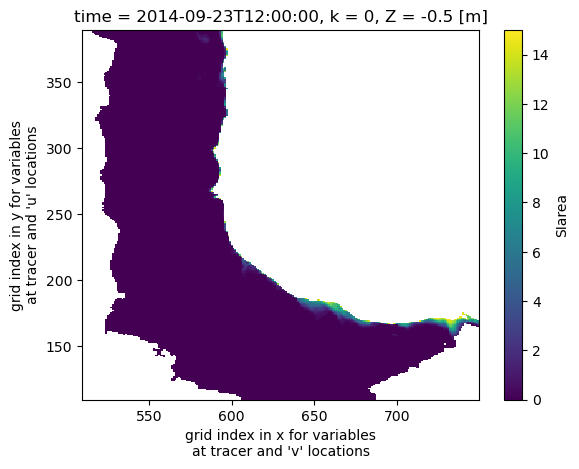

In [14]:
ice_yrs_masked.sel(time='2014').isel(time=0).plot();

## 2. Calculate FWC

In [15]:
def calculate_fwc(salt_da, salt_ref, dz):
    """
    Calculate the freshwater content (fwc)

    Parameters:
    salt_da (xr.DataArray): Salinity data array with a 'k' dimension.
    salt_ref (float): Reference salinity value.
    dz (xr.DataArray): Layer thickness data array with the same 'k' dimension.

    Returns:
    xr.DataArray: Freshwater content summed over the 'k' dimension.
    """
    fwc = ((salt_ref - salt_da) / salt_ref * dz).sum(dim='k')
    return fwc

In [16]:
salt_yrs_10m = salt_yrs.isel(k=slice(0,7))

In [17]:
salt_yrs_10m.Z.values

array([-0.5  , -1.57 , -2.79 , -4.185, -5.78 , -7.595, -9.66 ],
      dtype=float32)

#### Identify reference salinity

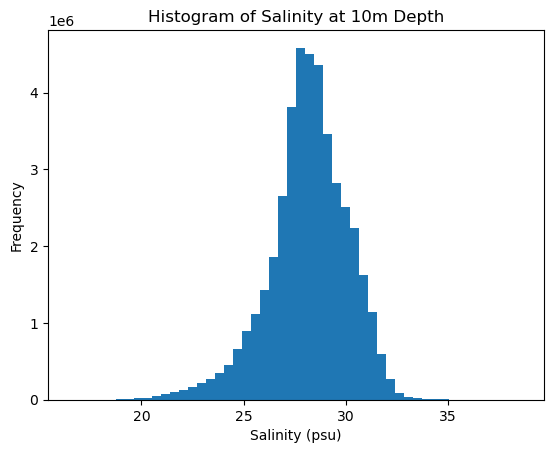

In [19]:
# flatten to 1D and drop NaNs
salt_values = salt_yrs_10m.isel(k=-1).values.flatten()
salt_values = salt_values[~np.isnan(salt_values)]

# plot histogram
plt.hist(salt_values, bins=50)  # adjust bins as needed
plt.xlabel('Salinity (psu)')
plt.ylabel('Frequency')
plt.title('Histogram of Salinity at 10m Depth')
plt.show()

In [22]:
# select 10 m level
salt_yrs_10m_depth = salt_yrs_10m.isel(k=-1)

# unravel
salinity_1d = salt_yrs_10m_depth.values.ravel()
salinity_1d = salinity_1d[np.isfinite(salinity_1d)]

# fit normal distribution
mu, sigma = stats.norm.fit(salinity_1d)

# calculate z-scores
z_scores = (salinity_1d - mu) / sigma

# keep values within a cutoff (+/- 3 sigma) - about 99.7% fall within 3*sigma
cutoff = 3
mask = np.abs(z_scores) <= cutoff
salinity_clean = salinity_1d[mask]

# find maximum without outliers
max_salinity = np.max(salinity_clean)

print(f"Mean: {mu:.2f}, Std Dev: {sigma:.2f}")
print(f"Maximum without outliers: {max_salinity:.2f}")

Mean: 28.16, Std Dev: 1.95
Maximum without outliers: 34.00


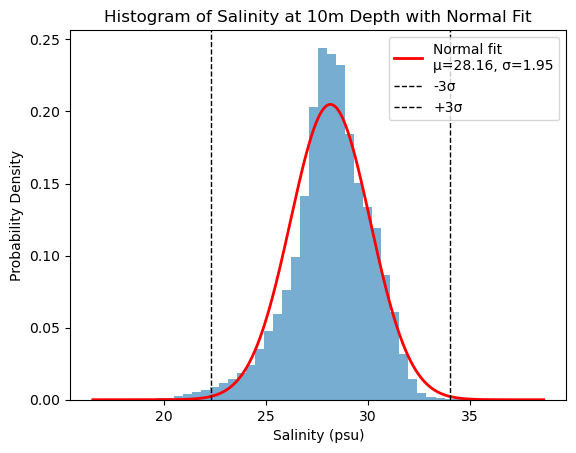

In [23]:
# Flatten to 1D and drop NaNs
salt_values = salt_yrs_10m.isel(k=-1).values.flatten()
salt_values = salt_values[~np.isnan(salt_values)]

# Fit normal distribution
mu, sigma = stats.norm.fit(salt_values)

# Histogram
counts, bins, patches = plt.hist(salt_values, bins=50, density=True, alpha=0.6)

# Normal distribution curve
x = np.linspace(bins[0], bins[-1], 1000)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Normal fit\nμ={mu:.2f}, σ={sigma:.2f}')

# +/- 3 sigma lines
plt.axvline(mu - 3*sigma, color='k', linestyle='--', linewidth=1, label='-3σ')
plt.axvline(mu + 3*sigma, color='k', linestyle='--', linewidth=1, label='+3σ')

# Labels
plt.xlabel('Salinity (psu)')
plt.ylabel('Probability Density')
plt.title('Histogram of Salinity at 10m Depth with Normal Fit')
plt.legend()
plt.show()

In [24]:
# calculate FWC

# define reference salinity
salt_ref = max_salinity # 34.0 psu

dz = HH_grid.isel(i=slice(510,750),j=slice(110,390)).drF.isel(k=slice(0,7)) # upper 10

fwc_beaufort_yrs = calculate_fwc(salt_yrs_10m, salt_ref, dz)

In [25]:
# mask land grid cells and where SIC>15% on ice minimum date
fwc_yrs_masked = fwc_beaufort_yrs.where(land_sic_mask_yr)

In [35]:
# save datasets
fwc_yrs_masked.name = 'fwc_masked'
fwc_yrs_masked.to_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_masked_Beaufort_final.ZARR')

## 3. Calculate MLD

In [26]:
def calculate_cp_from_profile(salinity, temperature, depth, lon=-137, lat=70):
    """
    Calculate specific heat capacity (cp) of seawater from depth, temperature, and salinity.
    
    Parameters:
    - salinity (array): salinity (PSU)
    - temperature (array): temperature (°C)
    - depth (array): depth values (m, negative downward)
    - lon (float): longitude for SA calculation
    - lat (float): latitude for pressure calculation
    
    Args:
    - cp (array): Specific heat capacity (J/kg/deg K) for each depth level
    """
    # Convert depth (m) to pressure (dbar)
    pressure = gsw.p_from_z(depth, lat)  # Negative depth because z is negative downward
    
    # Convert Practical Salinity (SP) to Absolute Salinity (SA)
    SA = gsw.SA_from_SP(salinity, pressure, lon, lat)
    
    # Compute specific heat capacity (cp) in J/(kg K)
    cp = gsw.cp_t_exact(SA, temperature, pressure)
    
    return cp

In [27]:
def calculate_mld(sigma0_array, density_threshold=0.03):
    """
    Calculate the Mixed Layer Depth (MLD) from a 4D potential density dataset (time, i, j, k),
    defined as the first depth where density exceeds surface density + threshold.

    If the profile contains no values exceeding the threshold but still has valid data,
    the MLD is defined as the bottommost valid depth in the profile.

    Handles land-masked grid cells (all-NaN profiles) by returning NaN.
    Compatible with Dask via rechunking along the vertical dimension (k).

    Args:
        sigma0_array (xr.DataArray): Potential density with dims (time, i, j, k) and vertical coord 'Z'.
        density_threshold (float): Threshold above surface density to define MLD (default 0.03 kg/m3).

    Returns:
        mld (xr.DataArray): MLD (depth) with dims (time, i, j).
        mld_k_index (xr.DataArray): Index along 'k' where threshold is first exceeded or last valid depth.
    """

    # Surface density at k=0
    rho_surface = sigma0_array.isel(k=0)

    # Density threshold
    threshold = rho_surface + density_threshold

    # Depth coordinate along 'k'
    depth_coord = sigma0_array['Z']

    # Ensure vertical dim is in a single chunk for Dask
    sigma0_array = sigma0_array.chunk(dict(k=-1))

    # Helper function to return both depth and index
    def first_exceeding_level_and_index(profile, depth, threshold_val):
        if np.all(np.isnan(profile)):
            return np.nan, np.nan
        for k in range(profile.shape[0]):
            if profile[k] > threshold_val and not np.isnan(profile[k]):
                return depth[k], k
        # If no threshold exceeded, return the deepest valid depth
        # Loop backwards over the vertical profile, from the bottom to the top.
        for k in range(profile.shape[0] - 1, -1, -1):
            if not np.isnan(profile[k]):
                return depth[k], k
        return np.nan, np.nan  # fallback - should not be hit

    # Apply with vectorization and dask support
    mld, mld_k_index = xr.apply_ufunc(
        first_exceeding_level_and_index,
        sigma0_array,
        depth_coord,
        threshold,
        input_core_dims=[["k"], ["k"], []],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float],
    )

    return mld, mld_k_index

In [28]:
def compute_potential_density(SALT_day, THETA_day, ref_lat=70):
    """
    Compute potential density anomaly referenced to 0 dbar.

    Args:
    - SALT_day: DataArray containing salinity (SALT), longitude (XC), and latitude (YC).
    - THETA_day: DataArray containing potential temperature (THETA).
    - ref_lat: Reference latitude for pressure calculation (default is 70°N).

    Returns:
    - sigma0: Potential density anomaly (kg/m3 - 1000).
    """
    # Convert depth (m) to pressure (dbar)
    p = gsw.p_from_z(SALT_day.Z, ref_lat)  # Depth is negative

    # Convert Practical Salinity (SP) to Absolute Salinity (SA)
    SA = gsw.SA_from_SP(SALT_day, p, SALT_day.XC, SALT_day.YC)

    # Convert Potential Temperature to Conservative Temperature
    CT = gsw.conversions.CT_from_pt(SA, THETA_day)

    # Calculate potential density anomaly referenced to 0 dbar
    sigma0 = gsw.sigma0(SA, CT)

    # Add metadata
    sigma0.name = 'potential_density'
    sigma0.attrs['long_name'] = 'potential_density'

    return sigma0 + 1000

In [29]:
# calculate potential density from in situ density
sigma = compute_potential_density(salt_yrs, temp_yrs, ref_lat=70)

In [30]:
# mask out land
sigma0 = sigma.where(grid_beaufort.mask_basin==1)

In [31]:
# calculate mld and the index of the mld along k coord
start = time.time()
mld_da, threshold_idx_da = calculate_mld(sigma0, density_threshold=0.03)
end = time.time()
print(f"Time taken: {np.round(end - start)} seconds")

Time taken: 0.0 seconds


In [34]:
# load into memory
mld_idx_da = threshold_idx_da.compute()

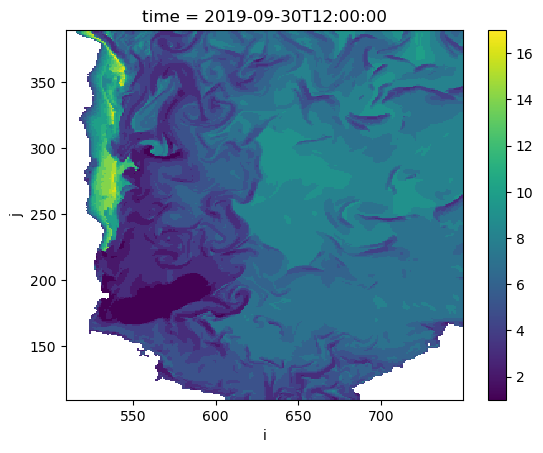

In [43]:
mld_idx_da.sel(time='2019-09-30').plot();

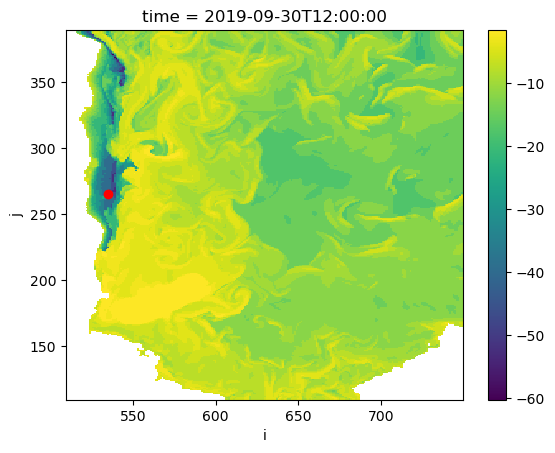

In [44]:
mld_da.sel(time='2019-09-30').plot()
plt.scatter(535,265,color='r');

In [45]:
# name dataset and save dataset to zarr
mld_da.name = 'mld'
mld_da.to_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/MLD/MLD_Beaufort_final.ZARR', safe_chunks=False)

## 4. Calculate OHC_s

In [32]:
def calculate_ohc(temp, salinity, density, layer_thickness, threshold_idx):
    """
    Calculate the Ocean Heat Content (OHC) relative to the freezing temperature in surface mixed layer for a time series of profiles.

    Args:
    - temp (xr.DataArray): 2D array of temperature (°C) with dimensions ['time', 'k'].
    - salinity (xr.DataArray): 2D array of salinity (PSU) with dimensions ['time', 'k'].
    - density (xr.DataArray): 2D array of seawater density (kg/m3) with dimensions ['time', 'k'].
    - layer_thickness (xr.DataArray): 1D array representing the thickness of each vertical layer (m).
    - threshold_idx (xr.DataArray): 1D array containing the maximum depth index for the MLD of each profile along the time series.

    Returns:
    - ohc (xr.DataArray): 3D array representing ocean heat content relative to the freezing temperature in the surface mixed layer for each profile (J/m2).
    """
    
    # specific heat capacity of seawater
    cp = calculate_cp_from_profile(salinity, temp, temp.Z, lon=temp.XC, lat=temp.YC)

    # # Given array of indices
    # indices = threshold_idx.compute()

    # Create mask for surface mixed layer
    mask = temp.k <= threshold_idx
    
    # Compute ocean heat content relative to freezing temperature per unit area
    temp_freezing = -1.96

    # Compute the weighted temperature anomaly and then OHC for the surface mixed layer
    weighted_temp_anomaly = (temp - temp_freezing) * layer_thickness
    weighted_temp_anomaly_layer = weighted_temp_anomaly.where(mask) # apply mask for specific depth layer
    ohc = (density * cp * weighted_temp_anomaly_layer).sum(dim='k')  # J/m^2

    # units check: (kg/m3)(J/(kg degC))(degC * m) = J/m2
    
    return ohc

In [36]:
# calculate OHC
start = time.time()
ohc_mld = calculate_ohc(temp_yrs, salt_yrs, sigma0, grid_beaufort.drF, mld_idx_da)
end = time.time()
print(f"Time taken: {np.round(end - start)} seconds")

Time taken: 23.0 seconds


In [48]:
# name dataset and save dataset to zarr
ohc_mld.name = 'ohc'
ohc_mld.to_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_MLD_Beaufort_final.ZARR')

### Calculate depth of pycnocline base

In [37]:
sigma0_plu = sigma0.where(fwc_yrs_masked>2)
sigma0_adj = sigma0.where(fwc_yrs_masked<2)

In [38]:
# add back Z coord
sigma0_plu = sigma0_plu.assign_coords(Z=('k', sigma0.Z.values*-1))
sigma0_adj = sigma0_adj.assign_coords(Z=('k', sigma0.Z.values*-1))

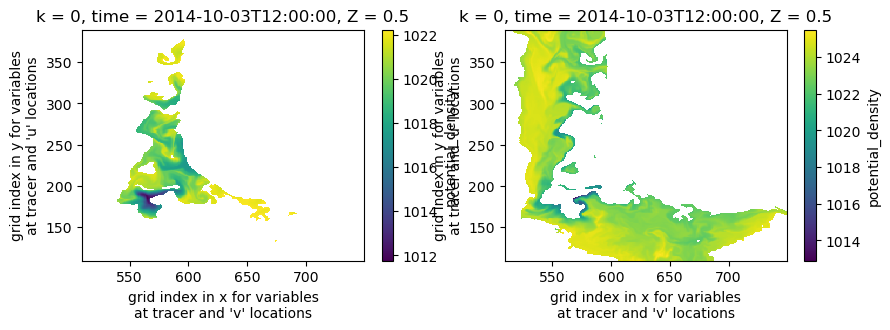

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[10,3])
sigma0_plu.isel(k=0,time=10).plot(ax=ax1);
sigma0_adj.isel(k=0,time=10).plot(ax=ax2);

In [40]:
# Select Dec 31 of each year - PLUME
sigma_dec_plu = sigma0_plu.sel(time=sigma0_plu['time'].dt.month == 12)
sigma_dec31_plu = sigma_dec_plu.sel(time=sigma_dec_plu['time'].dt.day == 31)

# Average over i and j
sigma_avg_plu_dec = sigma_dec_plu.mean(dim=['i', 'j', 'time']).compute()
sigma_avg_plu_dec31 = sigma_dec31_plu.mean(dim=['i', 'j', 'time']).compute()

In [41]:
# Select Dec 31 of each year - ADJACENT
sigma_dec_adj = sigma0_adj.sel(time=sigma0_adj['time'].dt.month == 12)
sigma_dec31_adj = sigma_dec_adj.sel(time=sigma_dec_adj['time'].dt.day == 31)

# Average over i and j
sigma_avg_adj_dec = sigma_dec_adj.mean(dim=['i', 'j', 'time']).compute()
sigma_avg_adj_dec31 = sigma_dec31_adj.mean(dim=['i', 'j', 'time']).compute()

In [42]:
# look at some profiles
sigma_subset = sigma_dec31_adj.isel(time=0,i=slice(None,None,20),j=slice(None,None,20))

In [43]:
# sanity check
print(sigma_dec31_plu.time.values)

['2014-12-31T12:00:00.000000000' '2015-12-31T12:00:00.000000000'
 '2016-12-31T12:00:00.000000000' '2017-12-31T12:00:00.000000000'
 '2018-12-31T12:00:00.000000000' '2019-12-31T12:00:00.000000000'
 '2020-12-31T12:00:00.000000000']


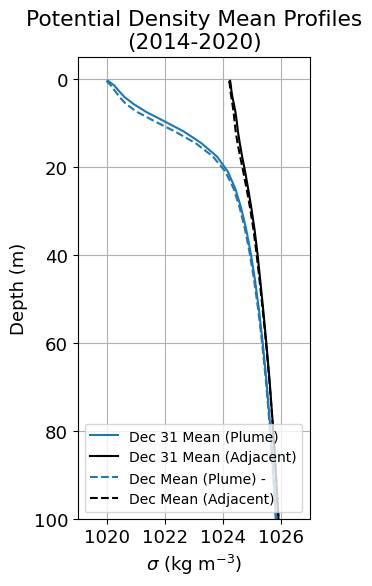

In [44]:
plt.rcParams['font.size'] = 13

sigma_avg_plu_dec31.plot(y='Z',figsize=[3,6],color='tab:blue',label='Dec 31 Mean (Plume)');
sigma_avg_adj_dec31.plot(y='Z',color='k',label='Dec 31 Mean (Adjacent)');
sigma_avg_plu_dec.plot(y='Z',linestyle='dashed',label='Dec Mean (Plume) - ');
sigma_avg_adj_dec.plot(y='Z',linestyle='dashed',color='k',label='Dec Mean (Adjacent)');
plt.title('Potential Density Mean Profiles\n(2014-2020)')
plt.legend(fontsize=10);
plt.grid()
plt.ylabel('Depth (m)')
plt.xlabel('$\sigma$ (kg m$^{-3}$)')
plt.xlim(1019,1027);
plt.ylim(100,-5);

plt.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/sigma_mean_dec_profiles.png',
            dpi=300, bbox_inches='tight')

### Calculate N2 using T/S

In [45]:
temp_plu = temp_yrs.where(fwc_yrs_masked>2)
temp_adj = temp_yrs.where(fwc_yrs_masked<2)

salt_plu = salt_yrs.where(fwc_yrs_masked>2)
salt_adj = salt_yrs.where(fwc_yrs_masked<2)

In [46]:
# Select Dec 31 from each year
dec31_mask = (temp_plu['time'].dt.month == 12) & (temp_plu['time'].dt.day == 31)

temp_dec31_plu = temp_plu.sel(time=dec31_mask)
salt_dec31_plu = salt_plu.sel(time=dec31_mask)

temp_dec31_adj = temp_adj.sel(time=dec31_mask)
salt_dec31_adj = salt_adj.sel(time=dec31_mask)

# Compute average vertical profile over time, i, j (leaves k)
temp_avg_prof_plu = temp_dec31_plu.mean(dim=['time', 'j', 'i'])
salt_avg_prof_plu = salt_dec31_plu.mean(dim=['time', 'j', 'i'])

temp_avg_prof_adj = temp_dec31_adj.mean(dim=['time', 'j', 'i'])
salt_avg_prof_adj = salt_dec31_adj.mean(dim=['time', 'j', 'i'])

In [47]:
# Get pressure for each Z level
depth = temp_yrs['Z'].values
latitude = 72

# Compute pressure from depth
pressure = gsw.p_from_z(depth, latitude)  # depth should be negative for z

# Now compute Absolute Salinity and Conservative Temperature
SA_plu = gsw.SA_from_SP(salt_avg_prof_plu.values, pressure, lon=-150, lat=latitude)
CT_plu = gsw.CT_from_t(SA_plu, temp_avg_prof_plu.values, pressure)

SA_adj = gsw.SA_from_SP(salt_avg_prof_adj.values, pressure, lon=-150, lat=latitude)
CT_adj = gsw.CT_from_t(SA_adj, temp_avg_prof_adj.values, pressure)

# Compute N2 and mid-level pressures
N2_plu, p_mid = gsw.Nsquared(SA_plu, CT_plu, pressure)
N2_adj, p_mid = gsw.Nsquared(SA_adj, CT_adj, pressure)

# Convert mid-pressure to mid-depth for plotting
z_mid = -gsw.z_from_p(p_mid, latitude)

# make it a DataArray
N2_plu_da = xr.DataArray(N2_plu, coords={'depth': z_mid}, dims=['depth'])
N2_plu_da.name = 'N_squared'
N2_plu_da.attrs['units'] = 's^-2'

N2_adj_da = xr.DataArray(N2_adj, coords={'depth': z_mid}, dims=['depth'])
N2_adj_da.name = 'N_squared'
N2_adj_da.attrs['units'] = 's^-2'

In [48]:
# Create a new depth array with 100 evenly spaced points between min and max
new_depth_coord = np.linspace(N2_plu_da['depth'].min().item(),
                              N2_plu_da['depth'].max().item(),100)

# Interpolate along the 'depth' dimension
N2_plu_interp = N2_plu_da.interp(depth=new_depth_coord)
N2_adj_interp = N2_adj_da.interp(depth=new_depth_coord)

In [49]:
threshold = 0.0001  # s^-2

# Only consider depths below 20 m to avoid detecting the surface wiggles in N2
deep_mask = N2_plu_interp['depth'] > 20

# Apply the threshold mask only at depths > 20 m
mask_plu = (N2_plu_interp < threshold).where(deep_mask)
mask_adj = (N2_adj_interp < threshold).where(deep_mask)

# Get the first depth (below 20 m) where N2 < threshold
pyc_depth_plu = N2_plu_interp['depth'].where(mask_plu).isel(depth=mask_plu.argmax(dim='depth'))
pyc_depth_adj = N2_adj_interp['depth'].where(mask_adj).isel(depth=mask_adj.argmax(dim='depth'))

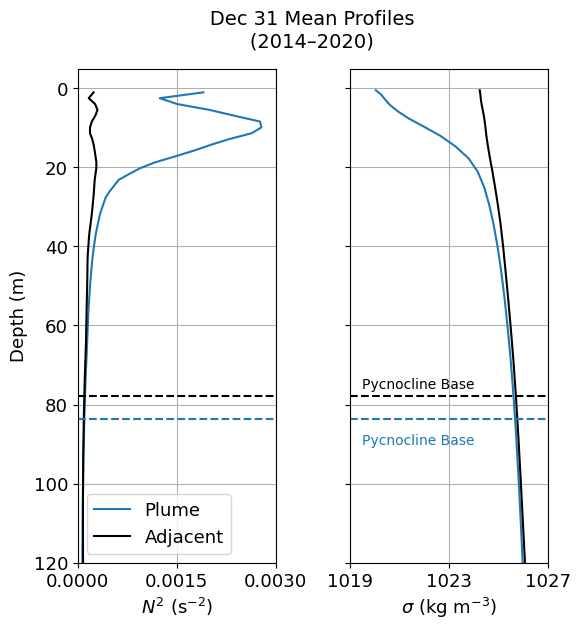

In [50]:
plt.rcParams['font.size'] = 13

fig, axs = plt.subplots(1, 2, figsize=(6, 7), sharey=True)

# ---- Left plot: N2 profiles ----
N2_plu_interp.plot(y='depth', ax=axs[0], color='tab:blue', label='Plume')
N2_adj_interp.plot(y='depth', ax=axs[0], color='k', label='Adjacent')

axs[0].axhline(y=pyc_depth_plu, color='tab:blue', linestyle='dashed')
axs[0].axhline(y=pyc_depth_adj, color='k', linestyle='dashed')
axs[0].grid(True)
axs[0].set_ylim(-5, 120)
axs[0].set_xlim(0, 0.003)
axs[0].set_xticks([0, 0.0015, 0.003])
axs[0].invert_yaxis()
axs[0].set_xlabel(r'$N^{2}$ (s$^{-2}$)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title("")
axs[0].legend()

# ---- Right plot: Potential Density profiles ----
sigma_avg_plu_dec31.plot(y='Z', ax=axs[1], color='tab:blue', label='Plume')
sigma_avg_adj_dec31.plot(y='Z', ax=axs[1], color='k', label='Adjacent')

axs[1].axhline(y=pyc_depth_plu, color='tab:blue', linestyle='dashed')
axs[1].axhline(y=pyc_depth_adj, color='k', linestyle='dashed')
axs[1].set_xlabel(r'$\sigma$ (kg m$^{-3}$)')
axs[1].set_xlim(1019, 1027)
axs[1].set_xticks([1019, 1023, 1027])
axs[1].grid(True)
axs[1].set_title('')
# axs[1].legend()
axs[1].set_ylabel("")

axs[1].text(1019.5, 76, 'Pycnocline Base', size=10, color='k')
axs[1].text(1019.5, 90, 'Pycnocline Base', size=10, color='tab:blue')

# ---- Shared settings ----
fig.suptitle("       Dec 31 Mean Profiles\n       (2014–2020)", fontsize=14,y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

fig.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/pyc_base_plots.png',
            dpi=300, bbox_inches='tight')

In [51]:
print(pyc_depth_plu.values)
print(pyc_depth_adj.values)

83.70155250157269
77.7967988034881


In [52]:
# take average of both depths
pyc_avg = np.mean([pyc_depth_plu,pyc_depth_adj])
print(pyc_avg)

# select closest model grid cell
depth_idx = np.argmin(abs(((sigma0.Z.values[10:22]*-1) - pyc_avg)))
pyc_depth_avg = sigma0.Z.values[10:22][depth_idx]
print(pyc_depth_avg)

80.7491756525304
-77.965


In [53]:
# figure out which k index is 78 m
sigma0.isel(k=19).Z.values

array(-77.965, dtype=float32)

## 5. Calculate OHC_p

In [54]:
def calculate_ohc_pyc(temp, salinity, density, layer_thickness, threshold_idx):
    """
    Calculate the Ocean Heat Content (OHC) relative to the freezing temperature between the depth of the mixed layer and the pycnocline for a time series of profiles.

    Args:
    - temp (xr.DataArray): 2D array of temperature (°C) with dimensions ['time', 'k'].
    - salinity (xr.DataArray): 2D array of salinity (PSU) with dimensions ['time', 'k'].
    - density (xr.DataArray): 2D array of seawater density (kg/m3) with dimensions ['time', 'k'].
    - layer_thickness (xr.DataArray): 1D array representing the thickness of each vertical layer (m).
    - threshold_idx (xr.DataArray): 1D array containing the maximum depth index for the MLD of each profile along the time series.

    Returns:
    - ohc (xr.DataArray): 3D array representing ocean heat content relative to the freezing temperature for each profile (J/m2).
    """
    
    # specific heat capacity of seawater
    cp = calculate_cp_from_profile(salinity, temp, temp.Z, lon=temp.XC, lat=temp.YC)

    # Given array of indices
    # indices = threshold_idx.compute()

    # Create mask for depths between surface mixed layer and winter mixed layer (down to ~78m in this case)
    mask = (temp.k > threshold_idx) & (temp.k < 19)
    
    # Compute ocean heat content relative to freezing temperature per unit area
    temp_freezing = -1.96

    # Compute the weighted temperature anomaly and then OHC for the surface mixed layer
    weighted_temp_anomaly = (temp - temp_freezing) * layer_thickness
    weighted_temp_anomaly_layer = weighted_temp_anomaly.where(mask) # apply mask for specific depth layer
    ohc = (density * cp * weighted_temp_anomaly_layer).sum(dim='k')  # J/m^2

    # units check: (kg/m3)(J/(kg degC))(degC * m) = J/m2
    
    return ohc, mask

In [55]:
HH_grid.isel(k_u=19).Zu.values # k=19 grid cell goes down to ~83 m

array(-82.83, dtype=float32)

In [56]:
# calculate OHC between MLD and pycnocline
start = time.time()
ohc_mld_pyc, mask_pyc = calculate_ohc_pyc(temp_yrs, salt_yrs, sigma0, grid_beaufort.drF, mld_idx_da)
end = time.time()
print(f"Time taken: {np.round(end - start)} seconds")

Time taken: 24.0 seconds


In [57]:
# sanity check to make sure mask is good
print(mask_pyc.sel(j=260,i=560).isel(time=10).values)
print(mld_idx_da.sel(j=260,i=560).isel(time=10).values)

[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False]
2.0


In [70]:
# name dataset and save dataset to zarr
ohc_mld_pyc.name = 'ohc_pyc'
ohc_mld_pyc.to_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_PYC_Beaufort_final.ZARR')